<a href="https://colab.research.google.com/github/mohammad2682/Covid-19/blob/master/CNN_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Adding Packages and Libraries**

In [2]:
import numpy as np 
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# **Cloning dataset from GitHub Repository**

In [3]:
!git clone https://github.com/mohammad2682/Covid19-Dataset

Cloning into 'Covid19-Dataset'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 2523 (delta 6), reused 0 (delta 0), pack-reused 2502
Receiving objects: 100% (2523/2523), 229.95 MiB | 36.99 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (4965/4965), done.


# Importing dataset

In [6]:
#importing train data from repo
import glob as glob
import skimage.transform as st
dl=['COVID','non-COVID']
dl=os.listdir('Covid19-Dataset/Covid-19-Dataset/train/')
xtrain=[]
p=0
for i in range(2):
  for fn in sorted(glob.glob('Covid19-Dataset/Covid-19-Dataset/train/'+dl[i]+'/*.png')):
    img = cv2.imread(fn)
    img=st.resize(img,(128,128))
    xtrain.append(img)

In [7]:
#importing test data from repo
dl=['COVID','non-COVID']
dl=os.listdir('Covid19-Dataset/Covid-19-Dataset/test/')
xtest=[]
p=0
for i in range(2):
  for fn in sorted(glob.glob('Covid19-Dataset/Covid-19-Dataset/test/'+dl[i]+'/*.png')):
    img = cv2.imread(fn)
    img=st.resize(img,(128,128))
    xtest.append(img)

In [8]:
#creating labels for train data
ytrain=[]
for i in range(2):
  for j in range(1000):
    ytrain.append(i)
#creating labels for test data    
ytest=[]
for j in range(252):
  ytest.append(0)
for j in range(230):
  ytest.append(1)

In [9]:
xtrain1=np.array(xtrain)
xtest1=np.array(xtest)
ytrain1=np.array(ytrain)
ytest1=np.array(ytest)

In [10]:
ytest1 = ytest1.reshape((ytest1.shape[0],1))
ytrain1 = ytrain1.reshape((ytrain1.shape[0],1))

# **Data PreProcessing**

In [11]:
image_size = 128
num_channels = 3
num_features = image_size * image_size * num_channels
num_classes = 2

num_train = 2000

In [ ]:
# Convert 4D arrays to 2D arrays
xtrain1 = xtrain1.reshape([-1, num_features])
xtest1  =  xtest1.reshape([-1, num_features])

print('Train data shape: {}'.format(xtrain1.shape))
print('Test  data shape: {}'.format(xtest1.shape))

Train data shape: (2000, 49152)
Test  data shape: (482, 49152)


In [ ]:
# convert pixel range from [0, 255] to [0., 1.]
X_train = xtrain1.astype('float16')
x_test  = xtest1.astype('float16')

mu = np.mean(X_train, axis=0)

X_train -= mu
X_train /= 255.0

x_test -= mu
x_test /= 255.0

## ONE-hot encoding

In [12]:
y_train = keras.utils.to_categorical(ytrain1, num_classes)
y_test  = keras.utils.to_categorical(ytest1,  num_classes)

print(y_train.shape)
print(y_test.shape)

(2000, 2)
(482, 2)


## **Converting dataset to 4D arrays**

In [ ]:
X_train = X_train.reshape((-1, image_size, image_size, num_channels))
x_test  =  x_test.reshape((-1, image_size, image_size, num_channels))

# **Creating a CNN with 2 Convolution Layers**

In [22]:
# Initialising the CNN
classifier = Sequential()
# Step 1 - Convolution
classifier.add(Conv2D(32, (7, 7), padding='same', input_shape = (128, 128, 3), activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.25))
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
#classifier.add(Conv2D(16, (1, 1), activation = 'relu'))
classifier.add(Conv2D(64, (7, 7), padding='same', activation = 'relu'))
classifier.add(Dropout(0.25))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a third convolutional layer
#classifier.add(Conv2D(16, (1, 1), activation = 'relu'))
classifier.add(Conv2D(128, (7, 7), padding='same', activation = 'relu'))
classifier.add(Dropout(0.25))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Step 3 - Flattening
classifier.add(GlobalAveragePooling2D())
# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(0.25))
classifier.add(Dense(units = num_classes, activation = 'sigmoid'))
# Compiling the CNN
optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
classifier.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 32)      4736      
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
dropout_9 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        100416    
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)       

In [16]:
bs = 32
ep = 10
classifier.fit(x= xtrain1, y= y_train, batch_size= bs, epochs= ep, validation_data=(xtest1, y_test))

Train on 2000 samples, validate on 482 samples
Epoch 1/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6478 - accuracy: 0.6195 - val_loss: 0.6994 - val_accuracy: 0.5187
Epoch 2/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6363 - accuracy: 0.6270 - val_loss: 0.7011 - val_accuracy: 0.3983
Epoch 3/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6291 - accuracy: 0.6375 - val_loss: 0.7185 - val_accuracy: 0.4046
Epoch 4/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6057 - accuracy: 0.6680 - val_loss: 0.7357 - val_accuracy: 0.4066
Epoch 5/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.5972 - accuracy: 0.6715 - val_loss: 0.7467 - val_accuracy: 0.4108
Epoch 6/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.5895 - accuracy: 0.6835 - val_loss: 0.9886 - val_accuracy: 0.5228
Epoch 7/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.5971 - accu

# **Data Augmentation**

In [17]:
from keras.preprocessing.image import ImageDataGenerator

In [19]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rescale=1./255,
                        rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True)

datagen.fit(xtrain1)
datagen = ImageDataGenerator(rescale=1./255)
datagen.fit(xtest1)

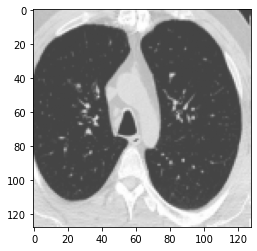

In [20]:
plt.imshow(xtrain1[2], cmap='gray')

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


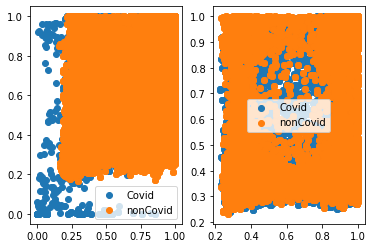

In [ ]:
plt.subplot(1,2,1)
plt.scatter(xtrain1[0:999,30],xtrain1[0:999,90],label='Covid')
plt.scatter(xtrain1[1000:1999,30],xtrain1[1000:1999,90],label='nonCovid')
plt.legend()
#"""
plt.subplot(1,2,2)
plt.scatter(xtest1[0:251,30],xtest1[0:251,90], label='Covid')
plt.scatter(xtest1[252:481,30],xtest1[252:481,90], label='nonCovid')
plt.legend()
#"""
plt.show()

In [23]:
bs = 16
ep = 50
history = classifier.fit_generator(datagen.flow(xtrain1, y_train, batch_size=bs),
                        steps_per_epoch=num_train//bs,
                        epochs=ep,
                        callbacks=[annealer, checkpoint],
                        validation_data=(xtest1, y_test))

Epoch 1/50
125/125 [==============================] - 4s 30ms/step - loss: 0.6930 - accuracy: 0.5060 - val_loss: 0.6972 - val_accuracy: 0.4772

Epoch 00001: val_loss improved from 7.69121 to 0.69720, saving model to model.h5
Epoch 2/50
125/125 [==============================] - 3s 27ms/step - loss: 0.6927 - accuracy: 0.5445 - val_loss: 0.6994 - val_accuracy: 0.4772

Epoch 00002: val_loss did not improve from 0.69720
Epoch 3/50
125/125 [==============================] - 3s 27ms/step - loss: 0.6924 - accuracy: 0.5665 - val_loss: 0.6975 - val_accuracy: 0.4004

Epoch 00003: val_loss did not improve from 0.69720
Epoch 4/50
125/125 [==============================] - 3s 27ms/step - loss: 0.6917 - accuracy: 0.5740 - val_loss: 0.7507 - val_accuracy: 0.5228

Epoch 00004: val_loss did not improve from 0.69720
Epoch 5/50
125/125 [==============================] - 3s 27ms/step - loss: 0.6910 - accuracy: 0.6105 - val_loss: 1.1395 - val_accuracy: 0.5228

Epoch 00005: val_loss did not improve from 0.6

KeyboardInterrupt: ignored

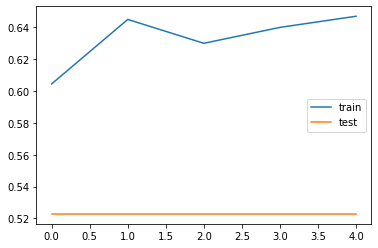

In [24]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

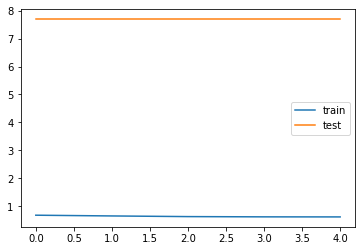

In [25]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()